In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation
from keras.layers import BatchNormalization, GlobalAveragePooling2D, concatenate, add
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

sns.set(style='white', context='notebook', palette='deep')

In [2]:
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import ModelCheckpoint, TensorBoard

In [3]:
random_seed = 4
np.random.seed(random_seed)

In [4]:
mnist = pd.read_csv("mnist.csv")
#print(mnist.head())
mnist_shuffled = mnist.sample(frac=1, random_state=random_seed).reset_index(drop=True)

In [5]:
##train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=1000, random_state=random_seed)

class_counter = [0]*10
#print(class_counter, mnist_shuffled["label"][0:10].values)
labels = mnist_shuffled["label"]
images = mnist_shuffled.drop(labels = ["label"],axis = 1)
train_x = []
train_y = []
test_x = []
test_y = []
for i in range(mnist_shuffled.shape[0]):
    label = labels.iloc[i]
    image = images.iloc[i].values
    if class_counter[label]<1000:
        test_x.append(image)
        test_y.append(label)
        class_counter[label] += 1
    else:
        train_x.append(image)
        train_y.append(label)
train_x = np.array(train_x)
train_y = np.array(train_y)
test_x = np.array(test_x)
test_y = np.array(test_y)
print(train_x.shape, test_x.shape)
print(class_counter)
#print(test_y)

(32000, 784) (10000, 784)
[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


0 3132
1 3684
2 3177
3 3351
4 3072
5 2795
6 3137
7 3401
8 3063
9 3188


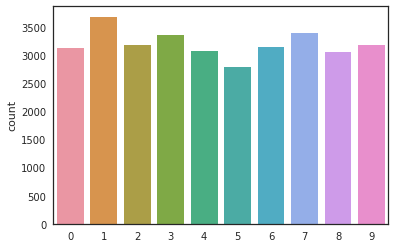

In [6]:
g = sns.countplot(train_y)
unique, counts = np.unique(train_y, return_counts=True)
for i in range(10):
    print(i, counts[i])

0 1000
1 1000
2 1000
3 1000
4 1000
5 1000
6 1000
7 1000
8 1000
9 1000


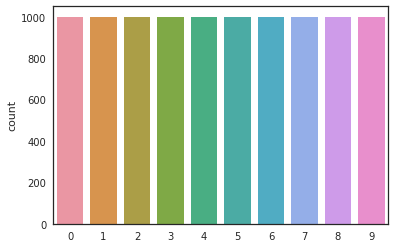

In [7]:
g = sns.countplot(test_y)
unique, counts = np.unique(test_y, return_counts=True)
for i in range(10):
    print(i, counts[i])

In [8]:
train_x = train_x / 255.0
test_x = test_x / 255.0

In [9]:
train_x = train_x.reshape(-1,28,28,1)
test_x = test_x.reshape(-1,28,28,1)

In [10]:
train_y = to_categorical(train_y, num_classes = 10)

In [11]:
test_y = to_categorical(test_y, num_classes = 10)

In [12]:
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = 0.1, random_state=random_seed)

Label: 4


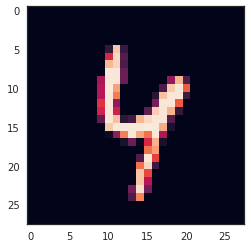

In [13]:
index = 10
print("Label:", np.argmax(train_y[index]))
g = plt.imshow(train_x[index][:,:,0])

In [35]:
def model_create(dropout=0.2, activation='relu'):
    """
    input = Input(shape=(28, 28, 1), name='input')
    conv_0_0 = Conv2D(512, (3, 3), padding="same", activation=activation, data_format="channels_last")(input)
    #conv_0_1 = Conv2D(512, (5, 5), padding="same", activation=activation, data_format="channels_last")(input)
    #conv_0 = concatenate([conv_0_0, conv_0_1])
    #mp_0 = MaxPooling2D()(conv_0_0)
    dp_0 = Dropout(dropout)(conv_0_0)
    conv_1 = Conv2D(512, (3, 3), padding="same", activation=activation, data_format="channels_last")(dp_0)
    #mp_0 = GlobalAveragePooling2D()(conv_1)
    mp_1 = MaxPooling2D()(conv_1)
    dp_1 = Dropout(dropout)(mp_1)
    
    model_flatten = Flatten()(dp_1)
    ---
    input = Input(shape=(28, 28, 1), name='input')
    conv_0 = Conv2D(128, (5, 5), padding="same", activation=activation, data_format="channels_last")(input)
    conv_1 = Conv2D(128, (5, 5), padding="same", activation=activation, data_format="channels_last")(conv_0)
    mp_0 = MaxPooling2D()(conv_1)
    dp_0 = Dropout(0.3)(mp_0)    
    
    conv_2 = Conv2D(64, (5, 5), padding="same", activation=activation, data_format="channels_last")(dp_0)
    conv_3 = Conv2D(64, (5, 5), padding="same", activation=activation, data_format="channels_last")(conv_2)
    mp_1 = MaxPooling2D()(conv_3)
    dp_1 = Dropout(0.3)(mp_1)
    
    conv_4 = Conv2D(128, (5, 5), padding="same", activation=activation, data_format="channels_last")(dp_1)
    conv_5 = Conv2D(128, (5, 5), padding="same", activation=activation, data_format="channels_last")(conv_4)
    mp_2 = MaxPooling2D()(conv_5)
    dp_2 = Dropout(0.2)(mp_2)    
    
    conv_6 = Conv2D(64, (5, 5), padding="same", activation=activation, data_format="channels_last")(dp_2)
    conv_7 = Conv2D(64, (5, 5), padding="same", activation=activation, data_format="channels_last")(conv_6)
    mp_3 = MaxPooling2D()(conv_7)
    dp_3 = Dropout(0.2)(mp_3)
    
    merge_0 = add([dp_1, dp_3])
    ----
    input = Input(shape=(28, 28, 1), name='input')
    conv_0 = Conv2D(128, (5, 5), padding="same", activation=activation, data_format="channels_last")(input)
    bn_0 = BatchNormalization()(conv_0)
    conv_1 = Conv2D(128, (5, 5), padding="same", activation=activation, data_format="channels_last")(bn_0)
    mp_0 = MaxPooling2D()(conv_1)
    bn_1 = BatchNormalization()(mp_0)
    
    conv_2 = Conv2D(128, (5, 5), padding="same", activation=activation, data_format="channels_last")(bn_1)
    bn_2 = BatchNormalization()(conv_2)
    conv_3 = Conv2D(128, (5, 5), padding="same", activation=activation, data_format="channels_last")(bn_2)
    mp_1= MaxPooling2D()(conv_3)
    
    
    model_flatten = Flatten()(mp_1)
    bn_3 = BatchNormalization()(model_flatten)
    """
    
    model = Sequential()
    
    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding="same", input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding="same"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding="same"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(128, (3, 3), strides=(1, 1), padding="same"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(128, (3, 3), strides=(1, 1), padding="same"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(256, (5, 5), strides=(2, 2), padding="same"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(256, (3, 3), strides=(1, 1), padding="same"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(256, (3, 3), strides=(1, 1), padding="same"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(256, (1, 1), strides=(1, 1), padding="same"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(512, (5, 5), strides=(2, 2), padding="same"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    
    #model = Model(inputs=[input], outputs=output)
    #optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

    return model

In [207]:
epochs = 10 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86
dropout = 0.35
activation = "relu"
verbose = 1
model_file_path = "results/mnist.h5"
model_out = "results/mnist_out.h5"

In [208]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(train_x)

In [209]:
tensorboard = TensorBoard(log_dir='graph', histogram_freq=0, write_graph=True, write_images=True)
checkpoint = ModelCheckpoint(model_file_path, monitor='acc', verbose=verbose, 
                             save_best_only=True, mode='max')
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

model = model_create(dropout=dropout, activation=activation)
print(model.summary())
#history = model.fit(x=[train_x], y=train_y,
#                    batch_size=batch_size, epochs=epochs, verbose=verbose,
#                    validation_data=(val_x, val_y), callbacks=[checkpoint, tensorboard])

history = model.fit_generator(datagen.flow(train_x,train_y, batch_size=batch_size),
                              epochs = epochs, validation_data = (val_x, val_y),
                              verbose = verbose, steps_per_epoch=train_x.shape[0] // batch_size
                              , callbacks=[checkpoint, tensorboard])

print("Max of acc: {}, val_acc: {}".
      format(max(history.history["acc"]), max(history.history["val_acc"])))
print("Min of loss: {}, val_loss: {}".
      format(min(history.history["loss"]), min(history.history["val_loss"])))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization_40 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
activation_39 (Activation)   (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_41 (Dropout)         (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 28, 28, 64)        36928     
_________________________________________________________________
batch_normalization_41 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
activation_40 (Activation)   (None, 28, 28, 64)        0         
__________

Epoch 8/10
333/334 [============================>.] - ETA: 0s - loss: 0.0636 - acc: 0.9821
Epoch 00008: acc improved from 0.97963 to 0.98206, saving model to results/mnist.h5
334/334 [==============================] - 23s 69ms/step - loss: 0.0635 - acc: 0.9821 - val_loss: 0.0808 - val_acc: 0.9825
Epoch 9/10
333/334 [============================>.] - ETA: 0s - loss: 0.0589 - acc: 0.9824
Epoch 00009: acc improved from 0.98206 to 0.98238, saving model to results/mnist.h5
334/334 [==============================] - 23s 69ms/step - loss: 0.0592 - acc: 0.9824 - val_loss: 0.0451 - val_acc: 0.9872
Epoch 10/10
333/334 [============================>.] - ETA: 0s - loss: 0.0557 - acc: 0.9839
Epoch 00010: acc improved from 0.98238 to 0.98395, saving model to results/mnist.h5
334/334 [==============================] - 23s 69ms/step - loss: 0.0556 - acc: 0.9839 - val_loss: 0.0353 - val_acc: 0.9881
Max of acc: 0.983945106574899, val_acc: 0.9881249943375587
Min of loss: 0.05557164141656337, val_loss: 0.

In [39]:
model.save_weights(model_out)

In [40]:
model.load_weights(model_out)

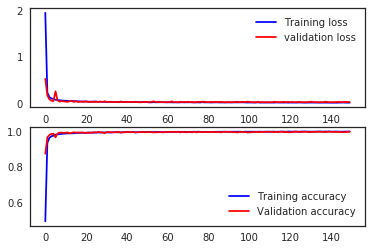

In [41]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [42]:
#print(history.history['acc'])
#print(history.history['val_acc'])

[0.49254718885223225, 0.9327157452269718, 0.9615866701990031, 0.9700842678418206, 0.9740196311881535, 0.9791042600707971, 0.980984877068709, 0.9823430994721586, 0.9839451063797734, 0.9850247196436444, 0.9857212443192989, 0.9860346802448242, 0.9871491198587228, 0.986766031465632, 0.9876715134028282, 0.9880587610299002, 0.989200106324626, 0.9897610872595757, 0.9893779986879657, 0.9895869560989653, 0.9901790020649684, 0.9901441758228825, 0.9902486545325339, 0.9912237890784501, 0.9904227858882698, 0.9910148316757538, 0.9917461827720134, 0.991258615320536, 0.9914009149916871, 0.9916039536330213, 0.9923034023257146, 0.9921640973988869, 0.9911541366191879, 0.992790969606976, 0.9928954483083241, 0.9928257958241523, 0.9929302745421069, 0.9924427072525422, 0.9930695794523281, 0.993489761552411, 0.9943213462248162, 0.9937661041528922, 0.9931392319448032, 0.9940098877810681, 0.9929302745421069, 0.9934178418067618, 0.9935919729839786, 0.9934526680488478, 0.9933133631137169, 0.9940795402569368, 0.99

In [43]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

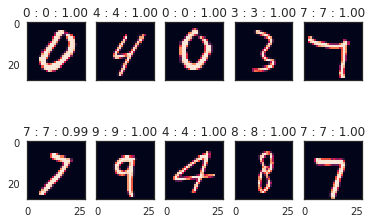

In [210]:
# Predict the values from the validation dataset
#test_x = test_x.values.reshape(-1,28,28,1)
#test_y = to_categorical(test_y, num_classes = 10)
#print(test_x.shape,test_x[:10])
pred_y = model.predict(test_x[:10])
#print(pred_y)
#print(np.argmax(pred_y, axis = 1))

index = 0
nrows = 2
ncols = 5
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
for row in range(nrows):
    for col in range(ncols):
        ax[row,col].imshow(test_x[index][:,:,0])
        ax[row,col].set_title("{} : {} : {:.2f}".format(np.argmax(pred_y[index]), 
                                                        np.argmax(test_y[index]), max(pred_y[index])))
        index = index+1

In [45]:
def class_statistic(confusion_mtx):
    true_positive = np.diag(confusion_mtx)
    false_positive = []
    for i in range(10):
        false_positive.append(np.sum(confusion_mtx[:, i]) - confusion_mtx[i, i])
    false_negative = []
    for i in range(10):
        false_negative.append(np.sum(confusion_mtx[i, :]) - confusion_mtx[i, i])
    true_negative = []
    for i in range(10):
        temp = np.delete(confusion_mtx, i, 0)
        temp = np.delete(temp, i, 1)
        true_negative.append(np.sum(temp))
    error_rate = 1.0 - np.sum(true_positive)/np.sum(confusion_mtx)
    
    true_positive = np.array(true_positive)
    false_positive = np.array(false_positive)
    false_negative = np.array(false_negative)
    true_negative = np.array(true_negative)

    print("True Positive per class:", true_positive)
    print("False Positive per class:", false_positive)
    print("False Negative per class:", false_negative)
    print("True Negative per class:", true_negative)

    true_positive_rate = true_positive / (true_positive + false_negative)
    false_positive_rate = false_positive / (false_positive + true_negative)
    print("True Positive Rate (Recall) per class")
    for i, rate in enumerate(true_positive_rate):
        print("  {}: {:.3f}%".format(i, rate*100))
    print("False Positive Rate per class")
    for i, rate in enumerate(false_positive_rate):
        print("  {}: {:.3f}%".format(i, rate*100))
    print("Error Rate: {:.2f}%".format(error_rate*100))

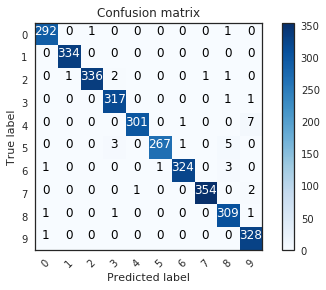

In [211]:
# Predict the values from the validation dataset
pred_y = model.predict(val_x)
# Convert predictions classes to one hot vectors 
pred_y_classes = np.argmax(pred_y, axis = 1) 
# Convert validation observations to one hot vectors
true_y = np.argmax(val_y, axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(true_y, pred_y_classes) 
#print(confusion_mtx)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 


True Positive per class: [292 334 336 317 301 267 324 354 309 328]
False Positive per class: [ 3  1  1  6  1  1  2  1 11 11]
False Negative per class: [2 0 5 2 8 9 5 3 3 1]
True Negative per class: [2903 2865 2858 2875 2890 2923 2869 2842 2877 2860]
True Positive Rate (Recall) per class
  0: 99.320%
  1: 100.000%
  2: 98.534%
  3: 99.373%
  4: 97.411%
  5: 96.739%
  6: 98.480%
  7: 99.160%
  8: 99.038%
  9: 99.696%
False Positive Rate per class
  0: 0.103%
  1: 0.035%
  2: 0.035%
  3: 0.208%
  4: 0.035%
  5: 0.034%
  6: 0.070%
  7: 0.035%
  8: 0.381%
  9: 0.383%
Error Rate: 1.19%
3200
(2834,) (366,)
True Positive per class: [263 323 314 314 267 252 294 204 273 323]
False Positive per class: [0 0 0 2 0 1 1 0 0 3]
False Negative per class: [0 0 0 0 2 1 1 2 1 0]
True Negative per class: [2571 2511 2520 2518 2565 2580 2538 2628 2560 2508]
True Positive Rate (Recall) per class
  0: 100.000%
  1: 100.000%
  2: 100.000%
  3: 100.000%
  4: 99.257%
  5: 99.605%
  6: 99.661%
  7: 99.029%
  8: 99

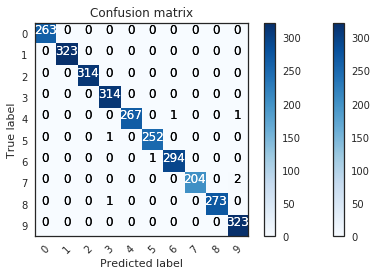

In [213]:
class_statistic(confusion_mtx)
post_process_prediction(pred_y, val_y, pred_true_matrix)

In [107]:
mnist_test = pd.read_csv("test_extended.csv")
mnist_test_y = mnist_test["label"]
mnist_test_x = mnist_test.drop(labels = ["label"],axis = 1)
print(mnist_test_x.shape)
print(mnist_test_y.shape)

(10000, 784)
(10000,)


In [108]:
mnist_test_x = mnist_test_x.values/255.0
mnist_test_x = mnist_test_x.reshape(-1,28,28,1)
mnist_test_y = to_categorical(mnist_test_y, num_classes = 10)

test_x_extended, val_x_extended, test_y_extended, val_y_extended = \
    train_test_split(mnist_test_x, mnist_test_y, test_size=0, random_state=random_seed)

(10000, 28, 28, 1)
(10000, 10)


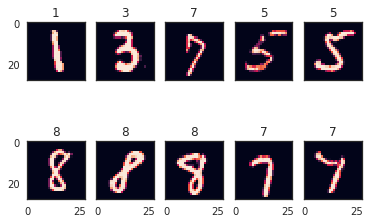

In [110]:
print(test_x_extended.shape)
print(test_y_extended.shape)

index = 0
nrows = 2
ncols = 5
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
for row in range(nrows):
    for col in range(ncols):
        ax[row,col].imshow(test_x_extended[index][:,:,0])
        ax[row,col].set_title("{}".format(np.argmax(test_y_extended[index])))
        index = index+1

In [ ]:
print("True Positive Rate:")
for i in range(10):
    TPR = confusion_mtx[i, i]/sum(confusion_mtx[i])
    print("Class {}: {:.03f}%".format(i, TPR*100.0))

print("False Positive Rate:")
for i in range(10):
    FPR = 1.0 - confusion_mtx[i, i]/sum(confusion_mtx[:, i])
    print("Class {}: {:.03f}%".format(i, FPR*100.0))

class_statistic(confusion_mtx)

True Positive per class: [995 994 995 992 996 996 997 999 995 989]
False Positive per class: [ 2  3  1  1  9  3 10 10  8  5]
False Negative per class: [ 5  6  5  8  4  4  3  1  5 11]
True Negative per class: [8998 8997 8999 8999 8991 8997 8990 8990 8992 8995]
True Positive Rate (Recall) per class
  0: 99.500%
  1: 99.400%
  2: 99.500%
  3: 99.200%
  4: 99.600%
  5: 99.600%
  6: 99.700%
  7: 99.900%
  8: 99.500%
  9: 98.900%
False Positive Rate per class
  0: 0.022%
  1: 0.033%
  2: 0.011%
  3: 0.011%
  4: 0.100%
  5: 0.033%
  6: 0.111%
  7: 0.111%
  8: 0.089%
  9: 0.056%
Error Rate: 0.52%


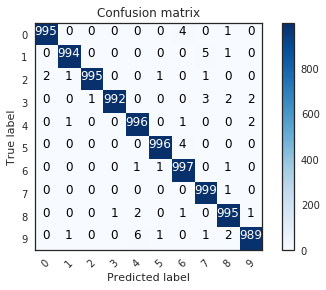

In [186]:
# Predict the values from the validation dataset
pred_y = model.predict(test_x)
# Convert predictions from one hot vectors to classes
pred_y_classes = np.argmax(pred_y, axis = 1) 
# Convert validation observations to one hot vectors
true_y = np.argmax(test_y, axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(true_y, pred_y_classes) 
#print(confusion_mtx)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

class_statistic(confusion_mtx)

True Positive per class: [ 977 1134 1030 1010  980  890  954 1026  971 1000]
False Positive per class: [2 3 0 1 8 3 3 3 2 3]
False Negative per class: [3 1 2 0 2 2 4 2 3 9]
True Negative per class: [9018 8862 8968 8989 9010 9105 9039 8969 9024 8988]
True Positive Rate (Recall) per class
  0: 99.694%
  1: 99.912%
  2: 99.806%
  3: 100.000%
  4: 99.796%
  5: 99.776%
  6: 99.582%
  7: 99.805%
  8: 99.692%
  9: 99.108%
False Positive Rate per class
  0: 0.022%
  1: 0.034%
  2: 0.000%
  3: 0.011%
  4: 0.089%
  5: 0.033%
  6: 0.033%
  7: 0.033%
  8: 0.022%
  9: 0.033%
Error Rate: 0.28%


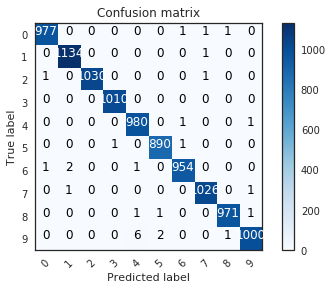

In [118]:
# Predict the values from the validation dataset
pred_y = model.predict(test_x_extended)
# Convert predictions from one hot vectors to classes
pred_y_classes = np.argmax(pred_y, axis = 1) 
# Convert validation observations to one hot vectors
true_y = np.argmax(test_y_extended, axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(true_y, pred_y_classes) 
#print(confusion_mtx)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

class_statistic(confusion_mtx)

In [192]:
for i, cls in enumerate(pred_y_classes):
    if cls == 9 and true_y[i] != cls:
        print("{} {} {:.7f}".format(cls, true_y[i], pred_y[i, true_y[i]]/pred_y[i, cls]))
        #print(cls, true_y[i], pred_y[i], pred_y[i, true_y[i]]/pred_y[i, cls])

9 3 0.0000000
9 4 0.0000182
9 4 0.9393066
9 3 0.0000001
9 8 0.0084525


In [202]:
pred_true_matrix = np.array(
[[1.    , 1.    , 0.001 , 1.    , 1.    , 0.04  , 0.02  , 1.    , 0.001 , 0.017 ],
 [1.    , 1.    , 1.    , 1.    , 0.0003, 1.    , 0.9   , 0.00001, 1.   , 0.17  ],
 [1.    , 1.    , 1.    , 0.03  , 1.    , 1.    , 1.    , 1.    , 0.002 , 0.025 ],
 [1.    , 0.47  , 0.027 , 1.    , 1.    , 0.002 , 1.    , 1.    , 1.    , 0.09  ],
 [1.    , 0.5   , 1.    , 1.    , 1.    , 1.    , 0.003 , 1.    , 0.006 , 0.002 ],
 [1.    , 1.    , 1.    , 0.005 , 1.    , 1.    , 1.    , 1.    , 1.    , 0.03  ],
 [0.007 , 0.1   , 1.    , 1.    , 0.001 , 0.0009, 1.    , 1.    , 1.    , 1.    ],
 [1.    , 0.003 , 0.003 , 0.2   , 1.    , 1.    , 1.    , 1.    , 1.    , 0.0002],
 [0.003 , 1.    , 1.    , 0.0002, 1.    , 0.4   , 0.0001, 0.01  , 1.    , 0.002 ],
 [1.    , 1.    , 1.    , 1.    , 0.05  , 1.    , 1.    , 1.    , 0.008 , 1.    ]])


In [182]:
#print(np.array2string(pred_true_matrix, separator=', ', precision=4, suppress_small=True))

In [204]:
def post_process_prediction(pred_y, test_y, pred_true_matrix):
    print(pred_y.shape[0])
    pred_y_good = np.array([])
    pred_y_notsure = np.array([])
    true_y_good = np.array([])
    true_y_notsure = np.array([])

    for i in range(pred_y.shape[0]):
        cls = np.argmax(pred_y[i])
        pred_is_good = True
        for j in range(10):
            if pred_true_matrix[cls, j] == 1.0:
                continue
            if pred_y[i, j]/pred_y[i, cls] >= pred_true_matrix[cls, j]:
                pred_is_good = False
        if pred_is_good:
            pred_y_good = np.append(pred_y_good, cls)
            true_y_good = np.append(true_y_good, np.argmax(test_y[i]))
        else:
            pred_y_notsure = np.append(pred_y_notsure, cls)
            true_y_notsure = np.append(true_y_notsure, np.argmax(test_y[i]))

    print(pred_y_good.shape, pred_y_notsure.shape)
    confusion_mtx = confusion_matrix(true_y_good, pred_y_good)
    # plot the confusion matrix
    plot_confusion_matrix(confusion_mtx, classes = range(10)) 

    confusion_mtx = confusion_matrix(true_y_good, pred_y_good) 
    plot_confusion_matrix(confusion_mtx, classes = range(10)) 

    class_statistic(confusion_mtx)
    print("Coverage: ", 1. - pred_y_notsure.shape[0]/pred_y.shape[0])

10000
(9882,) (118,)
True Positive per class: [993 975 992 990 987 988 995 985 986 980]
False Positive per class: [0 1 1 1 1 1 1 1 1 3]
False Negative per class: [0 0 1 4 1 1 1 0 1 2]
True Negative per class: [8889 8906 8888 8887 8893 8892 8885 8896 8894 8897]
True Positive Rate (Recall) per class
  0: 100.000%
  1: 100.000%
  2: 99.899%
  3: 99.598%
  4: 99.899%
  5: 99.899%
  6: 99.900%
  7: 100.000%
  8: 99.899%
  9: 99.796%
False Positive Rate per class
  0: 0.000%
  1: 0.011%
  2: 0.011%
  3: 0.011%
  4: 0.011%
  5: 0.011%
  6: 0.011%
  7: 0.011%
  8: 0.011%
  9: 0.034%
Error Rate: 0.11%
Coverage:  0.9882


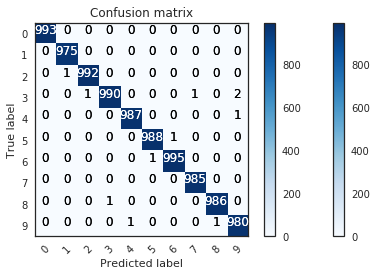

In [205]:
post_process_prediction(pred_y, test_y, pred_true_matrix)

10000
(9919,) (81,)
True Positive per class: [ 976 1122 1028 1007  971  885  951 1018  963  993]
False Positive per class: [0 1 0 0 0 1 1 1 0 1]
False Negative per class: [1 0 0 0 0 1 1 1 1 0]
True Negative per class: [8942 8796 8891 8912 8948 9032 8966 8899 8955 8925]
True Positive Rate (Recall) per class
  0: 99.898%
  1: 100.000%
  2: 100.000%
  3: 100.000%
  4: 100.000%
  5: 99.887%
  6: 99.895%
  7: 99.902%
  8: 99.896%
  9: 100.000%
False Positive Rate per class
  0: 0.000%
  1: 0.011%
  2: 0.000%
  3: 0.000%
  4: 0.000%
  5: 0.011%
  6: 0.011%
  7: 0.011%
  8: 0.000%
  9: 0.011%
Error Rate: 0.05%
Coverage:  0.9919


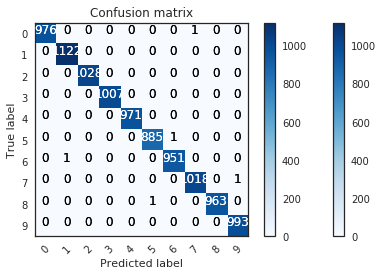

In [206]:
#test_y_old = test_y
#test_y = test_y_old
pred_y_extended = model.predict(test_x_extended)
post_process_prediction(pred_y_extended, test_y_extended, pred_true_matrix)

In [162]:
test_y = test_y_extended

In [200]:
threshold = np.array([0.99, 0.99, 0.99, 0.90, 0.999, 0.96, 0.999, 0.999, 0.99, 0.999])

10000
(9853,) (147,)
False Positive Rate:
Class 0: 0.101%
Class 1: 0.000%
Class 2: 0.000%
Class 3: 0.101%
Class 4: 0.102%
Class 5: 0.000%
Class 6: 0.101%
Class 7: 0.102%
Class 8: 0.403%
Class 9: 0.315%
True Positive per class: [994 984 987 991 982 994 990 980 989 950]
False Positive per class: [1 0 0 1 1 0 1 1 4 3]
False Negative per class: [0 0 1 4 1 1 1 0 1 3]
True Negative per class: [8858 8869 8865 8857 8869 8858 8861 8872 8859 8897]
True Positive Rate (Recall) per class
  0: 100.000%
  1: 100.000%
  2: 99.899%
  3: 99.598%
  4: 99.898%
  5: 99.899%
  6: 99.899%
  7: 100.000%
  8: 99.899%
  9: 99.685%
False Positive Rate per class
  0: 0.011%
  1: 0.000%
  2: 0.000%
  3: 0.011%
  4: 0.011%
  5: 0.000%
  6: 0.011%
  7: 0.011%
  8: 0.045%
  9: 0.034%
Error Rate: 0.12%
Coverage:  0.9853


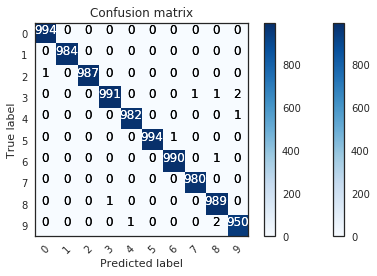

In [201]:
print(pred_y.shape[0])
#for i in pred_y.shape[0]:
pred_y_good = np.array([])
pred_y_notsure = np.array([])
true_y_good = np.array([])
true_y_notsure = np.array([])

#for i in range(50):
for i in range(pred_y.shape[0]):
    cls = np.argmax(pred_y[i])
    pred = pred_y[i][cls]
    #print(i, cls, pred)
    if pred >= threshold[cls]:
        pred_y_good = np.append(pred_y_good, cls)
        true_y_good = np.append(true_y_good, np.argmax(test_y[i]))
        #print("good: ", i, cls)
    else:
        pred_y_notsure = np.append(pred_y_notsure, cls)
        true_y_notsure = np.append(true_y_notsure, np.argmax(test_y[i]))
        #print("not sure: ", i, cls)
#print(pred_y_good, true_y_good)
#print(pred_y_notsure, true_y_notsure)
print(pred_y_good.shape, pred_y_notsure.shape)
confusion_mtx = confusion_matrix(true_y_good, pred_y_good) 
#print(confusion_mtx)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

confusion_mtx = confusion_matrix(true_y_good, pred_y_good) 
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

print("False Positive Rate:")
for i in range(10):
    FPR = 1.0 - confusion_mtx[i, i]/sum(confusion_mtx[:, i])
    print("Class {}: {:.03f}%".format(i, FPR*100.0))

class_statistic(confusion_mtx)
print("Coverage: ", 1. - pred_y_notsure.shape[0]/pred_y.shape[0])

(10000, 28, 28, 1)
(10000,)


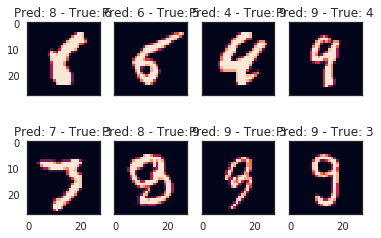

In [55]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (pred_y_classes - true_y != 0)

pred_y_classes_errors = pred_y_classes[errors]
pred_y_errors = pred_y[errors]
true_y_errors = true_y[errors]

print(test_x.shape)
print(errors.shape)
test_x_errors = test_x[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 4
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Pred: {} - True: {}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
pred_y_errors_prob = np.max(pred_y_errors, axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(pred_y_errors, true_y_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = pred_y_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_delta_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_delta_errors[-8:]

# Show the top 6 errors
display_errors(most_important_errors, test_x_errors, pred_y_classes_errors, true_y_errors)

In [ ]:
print(train_x.shape, test_x.shape)